# single-cell Progeny Production analysis
This notebook provides a central place to integrate and analyze transcriptome and progeny production data.

## Notebook setup
Import python modules:

In [1]:
from IPython.display import display

from dms_variants.constants import CBPALETTE

import pandas as pd

import plotnine as p9

import scipy

import statsmodels.stats.multitest

Hardcode input data for this analysis.

In [2]:
viral_tag_by_cell_csv = 'results/viral_tags_bcs_in_cells/scProgenyProduction_trial3_cell_barcodes_with_viral_tags.csv.gz'
viral_bc_background_freq_csv = 'results/viral_fastq10x/scProgenyProduction_trial3_viral_bc_background_freq.csv.gz'
viral_bc_in_progeny_freq_csv = 'results/viral_progeny/scProgenyProduction_trial3_viral_bc_in_progeny_freq.csv.gz'
expt = 'scProgenyProduction_trial3'
plot = 'results/viral_fastq10x/scProgenyProduction_trial3_viral_bc_correlations.pdf'
barcoded_viral_genes = ['fluHA', 'fluNA']

Set plotnine theme

In [3]:
p9.theme_set(p9.theme_classic())

## Correlation between transcripts and progeny
This section plots the correlation between viral barcode expression in the transcriptome and viral barcode fraction in the progeny datasets (supernatant or second infection).

### Organize data
First, read the cell barcodes and tags into a pandas dataframe. Only keep relevant columns.

In [4]:
all_cells = pd.read_csv(viral_tag_by_cell_csv)
all_cells = all_cells[['cell_barcode',
                       'infected',
                       'infecting_viral_tag']]
display(all_cells)

,cell_barcode,infected,infecting_viral_tag
0,AAACCCAGTAACAAGT,False,none
1,AAACCCATCATTGCTT,False,none
2,AAACGAAAGATGTTGA,False,none
3,AAACGAAGTACTTCCC,True,both
4,AAACGAAGTAGACGTG,True,wt
...,...,...,...
3363,TTTGATCTCCCGTTCA,False,none
3364,TTTGATCTCGCATTGA,True,wt
3365,TTTGGAGAGTTGCCTA,False,none
3366,TTTGGAGGTATCGTTG,True,wt


Next, read the viral barcode frequencies from the transcriptome.

In [5]:
transcriptome_viral_bc_freqs = pd.read_csv(viral_bc_background_freq_csv)
assert set(transcriptome_viral_bc_freqs['gene']) == set(barcoded_viral_genes), \
       "Barcoded genes in barcode counts do not match expectation."
display(transcriptome_viral_bc_freqs)

,cell_barcode,infected,infecting_viral_tag,frac_viral_UMIs,gene,viral_barcode,frac_viral_bc_UMIs,reject_uninfected
0,AAACCCAGTAACAAGT,False,none,0.000048,fluHA,NaN,0.000000,False
1,AAACCCATCATTGCTT,False,none,0.000051,fluHA,NaN,0.000000,False
2,AAACGAAAGATGTTGA,False,none,0.000204,fluHA,NaN,0.000000,False
3,AAACGAAGTACTTCCC,True,both,0.448272,fluHA,NaN,0.000000,False
4,AAACGAAGTAGACGTG,True,wt,0.040116,fluHA,AAGTAAGCGACATGAG,0.001731,True
...,...,...,...,...,...,...,...,...
9185,TTTGATCTCCCGTTCA,False,none,0.000109,fluNA,NaN,0.000000,False
9186,TTTGATCTCGCATTGA,True,wt,0.063156,fluNA,NaN,0.000000,False
9187,TTTGGAGAGTTGCCTA,False,none,0.000070,fluNA,NaN,0.000000,False
9188,TTTGGAGGTATCGTTG,True,wt,0.024534,fluNA,ACATCTTATTTACACG,0.000230,True


Read the viral barcode frequencies from the progeny. **For now just work with supernatant data. Remove second_infection frequencies.**

In [6]:
progeny_viral_bc_freqs = pd.read_csv(viral_bc_in_progeny_freq_csv)
assert set(progeny_viral_bc_freqs['gene']) == set(barcoded_viral_genes), \
       "Barcoded genes in barcode counts do not match expectation."
progeny_viral_bc_freqs = (progeny_viral_bc_freqs
                          .rename(columns={'barcode': 'viral_barcode',
                                           'tag': 'infecting_viral_tag',
                                           'mean_freq': 'freq_progeny'}))
progeny_viral_bc_freqs = (progeny_viral_bc_freqs
                          .query('source == "supernatant"'))
progeny_viral_bc_freqs = progeny_viral_bc_freqs.drop(columns = 'source')
display(progeny_viral_bc_freqs)

,infecting_viral_tag,gene,viral_barcode,freq_progeny
0,syn,fluHA,AAAAAAGCACGAGCAG,2.507618e-07
1,syn,fluHA,AAAAAATCCTTCAGCA,2.574453e-07
2,syn,fluHA,AAAAAATGGCGACGCT,2.574453e-07
3,syn,fluHA,AAAAAATTGGTTTACT,2.574453e-07
4,syn,fluHA,AAAAACACTCACAAGT,2.574453e-07
...,...,...,...,...
57485,wt,fluNA,TTTTTCCCTTACATAT,4.799773e-07
57486,wt,fluNA,TTTTTCTTACGATCAC,4.799773e-07
57487,wt,fluNA,TTTTTCTTCGAGATAG,4.799773e-06
57488,wt,fluNA,TTTTTGGGATCATTGC,9.599545e-07


Merge dataframes to one. This will be done in two steps. First, merge transcriptome frequencies with all cells tag info.  Then, merge supernatant frequencies into this dataframe.

Structure of the final dataframe should be as follows:
1. Cell barcode
2. Infected
3. Infecting viral tag
4. Gene
5. Viral barcode
6. Frequency in transcriptome (`frac_viral_bc_UMIs`)
7. Frequency in supernatant sequencing (`freq_progeny`)

In [7]:
viral_bc_freqs = pd.merge(
    left=pd.concat([all_cells.assign(gene=gene)
                    for gene in barcoded_viral_genes]),
    right=transcriptome_viral_bc_freqs,
    how='outer',
    on=['cell_barcode', 'gene', 'infected', 'infecting_viral_tag'],
    validate='one_to_many')

assert (viral_bc_freqs['cell_barcode'].unique() ==
        all_cells['cell_barcode'].unique()).all(), \
       "Cell barcodes in merged dataframe don't " \
       "match barcodes in source data."
assert (viral_bc_freqs['viral_barcode'].nunique() ==
        transcriptome_viral_bc_freqs['viral_barcode'].nunique()), \
       "Number of viral barcodes in merged dataframe doesn't " \
       "match number of barcodes in source data."

viral_bc_freqs = pd.merge(
    left=viral_bc_freqs,
    right=progeny_viral_bc_freqs,
    how='outer',
    on=['viral_barcode', 'gene', 'infecting_viral_tag'])
# Need to think of what asserts to include here

display(viral_bc_freqs)

,cell_barcode,infected,infecting_viral_tag,gene,frac_viral_UMIs,viral_barcode,frac_viral_bc_UMIs,reject_uninfected,freq_progeny
0,AAACCCAGTAACAAGT,False,none,fluHA,0.000048,NaN,0.0,False,NaN
1,AAACCCATCATTGCTT,False,none,fluHA,0.000051,NaN,0.0,False,NaN
2,AAACGAAAGATGTTGA,False,none,fluHA,0.000204,NaN,0.0,False,NaN
3,AAACGCTCAAATGATG,False,none,fluHA,0.000107,NaN,0.0,False,NaN
4,AAACGCTCATGGACAG,False,none,fluHA,0.000119,NaN,0.0,False,NaN
...,...,...,...,...,...,...,...,...,...
66332,NaN,NaN,wt,fluNA,NaN,TTTTTCCCTTACATAT,NaN,NaN,4.799773e-07
66333,NaN,NaN,wt,fluNA,NaN,TTTTTCTTACGATCAC,NaN,NaN,4.799773e-07
66334,NaN,NaN,wt,fluNA,NaN,TTTTTCTTCGAGATAG,NaN,NaN,4.799773e-06
66335,NaN,NaN,wt,fluNA,NaN,TTTTTGGGATCATTGC,NaN,NaN,9.599545e-07


## Filtering
**I am not doing any filtering on this data yet. I will plot the data in its raw form first.**

*Potential filtering strategy in future:*
>I will need to filter these data further before plotting. Here are the parameters I am using:
>1. Only look at cells called as infected.
>2. Only keep viral barcodes found in the transcriptome data, since these are the ones we can probe further in the transcriptome.
>3. Only look at viral barcodes called as significantly higher frequency than background (`reject_uninfected == True`)

### Plots

#### Viral transcription
***Note:*** `NA` values (0 counts) in the transcriptome data are plotted on the far left side of this graph at `1e-8`.

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/plotnine/layer.py:372: PlotnineWarning: stat_bin : Removed 4851 rows containing non-finite values.
/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/plotnine/guides/guides.py:197: PlotnineWarning: Cannot generate legend for the 'fill' aesthetic. Make sure you have mapped a variable to it


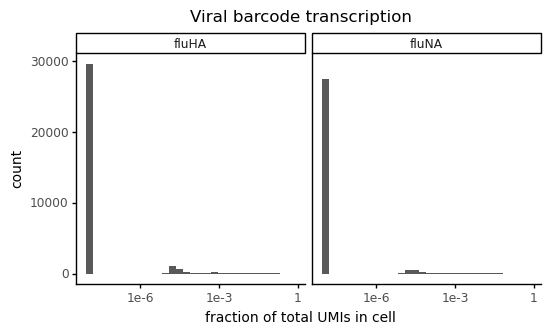

<ggplot: (8767494045278)>

In [8]:
fig = (p9.ggplot(viral_bc_freqs.fillna(1e-8),
                 p9.aes(x='frac_viral_bc_UMIs')) +
       p9.geom_histogram(bins=30) +
       p9.facet_grid('~gene') +
       p9.ggtitle(f'Viral barcode transcription') +
       p9.scale_x_log10() +
       p9.labs(x='fraction of total UMIs in cell') +
       p9.theme(figure_size=(6, 3),
                plot_title=p9.element_text(size=12),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center') +
       p9.scale_fill_manual(CBPALETTE[0:]))
display(fig)

Without the `NA` values:

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/plotnine/layer.py:372: PlotnineWarning: stat_bin : Removed 4851 rows containing non-finite values.
/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/plotnine/guides/guides.py:197: PlotnineWarning: Cannot generate legend for the 'fill' aesthetic. Make sure you have mapped a variable to it


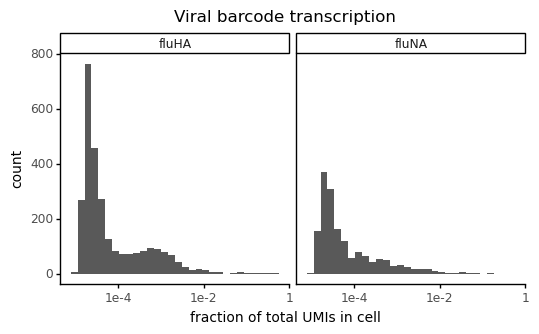

<ggplot: (8767495320525)>

In [9]:
fig = (p9.ggplot(viral_bc_freqs.query('frac_viral_bc_UMIs.notnull()', engine='python'),
                 p9.aes(x='frac_viral_bc_UMIs')) +
       p9.geom_histogram(bins=30) +
       p9.facet_grid('~gene') +
       p9.ggtitle(f'Viral barcode transcription') +
       p9.scale_x_log10() +
       p9.labs(x='fraction of total UMIs in cell') +
       p9.theme(figure_size=(6, 3),
                plot_title=p9.element_text(size=12),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center') +
       p9.scale_fill_manual(CBPALETTE[0:]))
display(fig)

#### Supernatant progeny production
***Note:*** `NA` values (0 counts) in the supernatant data are plotted on the far left side of this graph at `1e-8`.

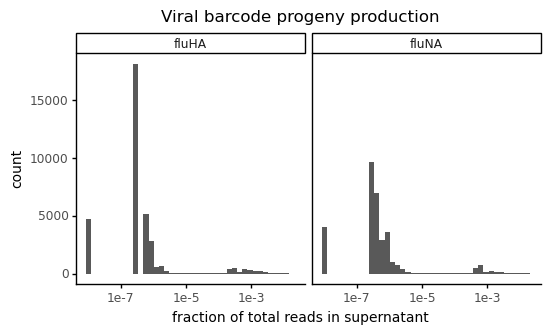

<ggplot: (8767493850179)>

In [10]:
fig = (p9.ggplot(viral_bc_freqs.fillna(1e-8),
                 p9.aes(x='freq_progeny')) +
       p9.geom_histogram(bins=40) +
       p9.facet_grid('~gene') +
       p9.ggtitle(f'Viral barcode progeny production') +
       p9.labs(x='fraction of total reads in supernatant') +
       p9.theme(figure_size=(6, 3),
                plot_title=p9.element_text(size=12),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center') +
       p9.scale_x_log10())
display(fig)

Without the 0 values:

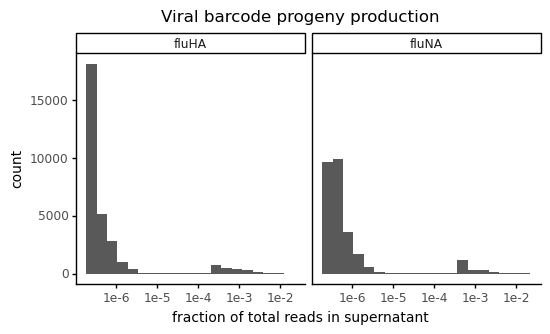

<ggplot: (8767493772153)>

In [11]:
fig = (p9.ggplot(viral_bc_freqs.query('freq_progeny.notnull()', engine='python'),
                 p9.aes(x='freq_progeny')) +
       p9.geom_histogram(bins=20) +
       p9.facet_grid('~gene') +
       p9.ggtitle(f'Viral barcode progeny production') +
       p9.labs(x='fraction of total reads in supernatant') +
       p9.theme(figure_size=(6, 3),
                plot_title=p9.element_text(size=12),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center') +
       p9.scale_x_log10())
display(fig)

#### Correlation of viral transcription and progeny production

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10


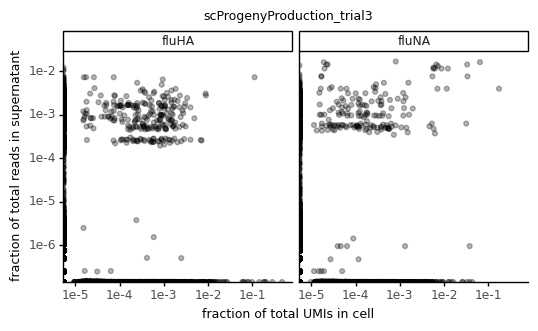

<ggplot: (8767494049702)>

In [12]:
fig = (p9.ggplot(viral_bc_freqs.fillna(0),
                 p9.aes(x='frac_viral_bc_UMIs',
                        y='freq_progeny')) +
       p9.geom_point(alpha=0.3) +
       p9.facet_grid('~gene') +
       p9.ggtitle(f'{expt}') +
       p9.scale_x_log10() +
       p9.scale_y_log10() +
       p9.labs(x='fraction of total UMIs in cell',
               y='fraction of total reads in supernatant') +
       p9.theme(figure_size=(6, 3),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center'))
display(fig)

Export correlation plot:

In [13]:
print(f"Saving correlation plot to {plot}")
p9.ggsave(plot=fig, filename=plot, verbose=False)

Saving correlation plot to results/viral_fastq10x/scProgenyProduction_trial3_viral_bc_correlations.pdf


/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10


## Annotating plot

### Infected

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10


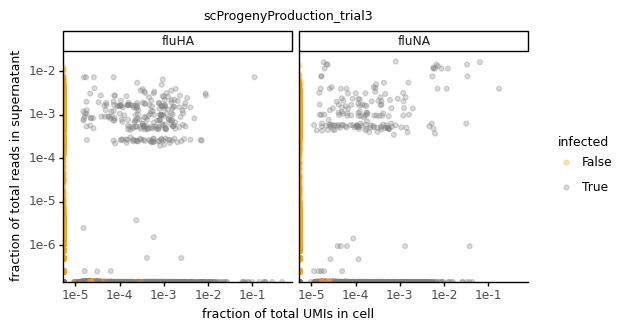

<ggplot: (8767493788401)>

In [14]:
fig = (p9.ggplot(viral_bc_freqs.fillna(0),
                 p9.aes(x='frac_viral_bc_UMIs',
                        y='freq_progeny',
                        color='infected')) +
       p9.geom_point(alpha=0.3) +
       p9.facet_grid('~gene') +
       p9.ggtitle(f'{expt}') +
       p9.scale_x_log10() +
       p9.scale_y_log10() +
       p9.labs(x='fraction of total UMIs in cell',
               y='fraction of total reads in supernatant') +
       p9.theme(figure_size=(6, 3),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center') +
       p9.scale_color_manual(values=['orange','grey']))
display(fig)

### Variant

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10


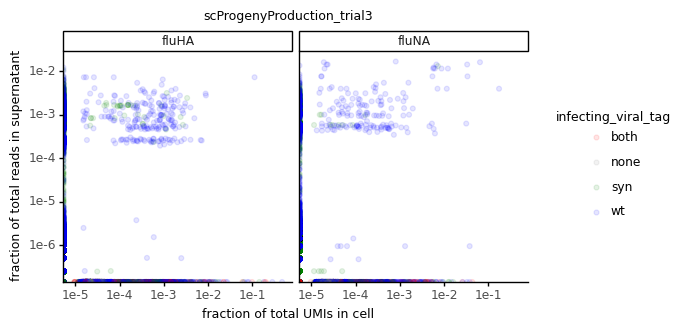

<ggplot: (8767488037596)>

In [15]:
fig = (p9.ggplot(viral_bc_freqs.fillna(0),
                 p9.aes(x='frac_viral_bc_UMIs',
                        y='freq_progeny',
                        color='infecting_viral_tag')) +
       p9.geom_point(alpha=0.1) +
       p9.facet_grid('~gene') +
       p9.ggtitle(f'{expt}') +
       p9.scale_x_log10() +
       p9.scale_y_log10() +
       p9.labs(x='fraction of total UMIs in cell',
               y='fraction of total reads in supernatant') +
       p9.theme(figure_size=(6, 3),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center') +
       p9.scale_color_manual(values=['red','grey','green','blue']))
display(fig)

### Above background frequency

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10


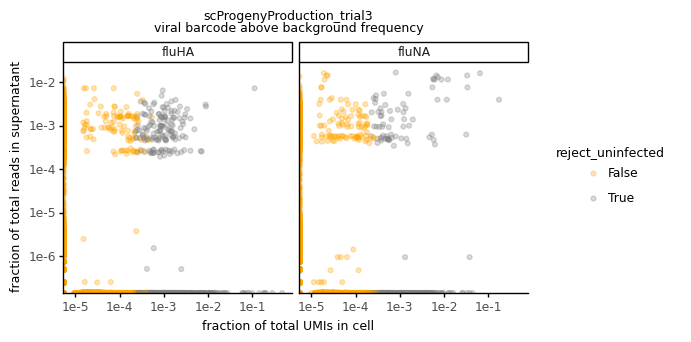

<ggplot: (8767482874646)>

In [16]:
fig = (p9.ggplot(viral_bc_freqs.fillna(0),
                 p9.aes(x='frac_viral_bc_UMIs',
                        y='freq_progeny',
                        color='reject_uninfected')) +
       p9.geom_point(alpha=0.3) +
       p9.facet_grid('~gene') +
       p9.ggtitle(f'{expt}\n'
                  'viral barcode above background frequency') +
       p9.scale_x_log10() +
       p9.scale_y_log10() +
       p9.labs(x='fraction of total UMIs in cell',
               y='fraction of total reads in supernatant') +
       p9.theme(figure_size=(6, 3),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center') +
       p9.scale_color_manual(values=['orange','grey']))
display(fig)

### Viral barcode is found in at least one infected cell
I will label each viral barcode by whether it is found above background frequency in at least one cell labelled as infected.

In [17]:
in_infected_cell = (pd.DataFrame(viral_bc_freqs
                                .query('reject_uninfected == True '
                                       'and infected == True')
                                ['viral_barcode']
                                .unique())
                    .rename(columns={0:'viral_barcode'}))
in_infected_cell['in_infected_cell'] = True

viral_bc_freqs = pd.merge(
                    left=viral_bc_freqs,
                    right=in_infected_cell,
                    on=['viral_barcode'],
                    how='left')

viral_bc_freqs['in_infected_cell'] = viral_bc_freqs['in_infected_cell'].fillna(False)
viral_bc_freqs

,cell_barcode,infected,infecting_viral_tag,gene,frac_viral_UMIs,viral_barcode,frac_viral_bc_UMIs,reject_uninfected,freq_progeny,in_infected_cell
0,AAACCCAGTAACAAGT,False,none,fluHA,0.000048,NaN,0.0,False,NaN,False
1,AAACCCATCATTGCTT,False,none,fluHA,0.000051,NaN,0.0,False,NaN,False
2,AAACGAAAGATGTTGA,False,none,fluHA,0.000204,NaN,0.0,False,NaN,False
3,AAACGCTCAAATGATG,False,none,fluHA,0.000107,NaN,0.0,False,NaN,False
4,AAACGCTCATGGACAG,False,none,fluHA,0.000119,NaN,0.0,False,NaN,False
...,...,...,...,...,...,...,...,...,...,...
66332,NaN,NaN,wt,fluNA,NaN,TTTTTCCCTTACATAT,NaN,NaN,4.799773e-07,False
66333,NaN,NaN,wt,fluNA,NaN,TTTTTCTTACGATCAC,NaN,NaN,4.799773e-07,False
66334,NaN,NaN,wt,fluNA,NaN,TTTTTCTTCGAGATAG,NaN,NaN,4.799773e-06,False
66335,NaN,NaN,wt,fluNA,NaN,TTTTTGGGATCATTGC,NaN,NaN,9.599545e-07,False


/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10


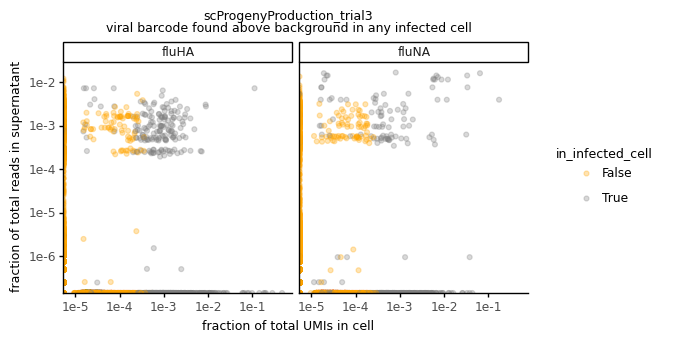

<ggplot: (8767490300850)>

In [18]:
fig = (p9.ggplot(viral_bc_freqs.fillna(0),
                 p9.aes(x='frac_viral_bc_UMIs',
                        y='freq_progeny',
                        color='in_infected_cell')) +
       p9.geom_point(alpha=0.3) +
       p9.facet_grid('~gene') +
       p9.ggtitle(f'{expt}\n'
                  'viral barcode found above background in any infected cell') +
       p9.scale_x_log10() +
       p9.scale_y_log10() +
       p9.labs(x='fraction of total UMIs in cell',
               y='fraction of total reads in supernatant') +
       p9.theme(figure_size=(6, 3),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center') +
       p9.scale_color_manual(values=['orange','grey']))
display(fig)

### Cells per viral barcode
I want to annotate viral barcodes that are found above background in multiple cells. This should be very unlikely in a low MOI infection.

Calculate the number of cells each viral barcode is found in:

In [19]:
n_cell_bc = (viral_bc_freqs
             .query('(reject_uninfected == True) and '
                    '(cell_barcode.notna())',
                    engine='python')
             .groupby(['infecting_viral_tag',
                       'gene',
                       'viral_barcode',
                       'reject_uninfected'])
             ['cell_barcode']
             .nunique()
             .reset_index()
             .rename(columns={'cell_barcode': 'n_cell_bc'}))

n_cell_bc

viral_bc_freqs = pd.merge(
    viral_bc_freqs,
    n_cell_bc,
    on=['infecting_viral_tag',
        'gene',
        'viral_barcode',
        'reject_uninfected'],
    how='left')

viral_bc_freqs

,cell_barcode,infected,infecting_viral_tag,gene,frac_viral_UMIs,viral_barcode,frac_viral_bc_UMIs,reject_uninfected,freq_progeny,in_infected_cell,n_cell_bc
0,AAACCCAGTAACAAGT,False,none,fluHA,0.000048,NaN,0.0,False,NaN,False,NaN
1,AAACCCATCATTGCTT,False,none,fluHA,0.000051,NaN,0.0,False,NaN,False,NaN
2,AAACGAAAGATGTTGA,False,none,fluHA,0.000204,NaN,0.0,False,NaN,False,NaN
3,AAACGCTCAAATGATG,False,none,fluHA,0.000107,NaN,0.0,False,NaN,False,NaN
4,AAACGCTCATGGACAG,False,none,fluHA,0.000119,NaN,0.0,False,NaN,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...
66332,NaN,NaN,wt,fluNA,NaN,TTTTTCCCTTACATAT,NaN,NaN,4.799773e-07,False,NaN
66333,NaN,NaN,wt,fluNA,NaN,TTTTTCTTACGATCAC,NaN,NaN,4.799773e-07,False,NaN
66334,NaN,NaN,wt,fluNA,NaN,TTTTTCTTCGAGATAG,NaN,NaN,4.799773e-06,False,NaN
66335,NaN,NaN,wt,fluNA,NaN,TTTTTGGGATCATTGC,NaN,NaN,9.599545e-07,False,NaN


Plot distribution of cell barcode per viral barcode. Only look at viral barcodes found above background and present in the transcriptome.

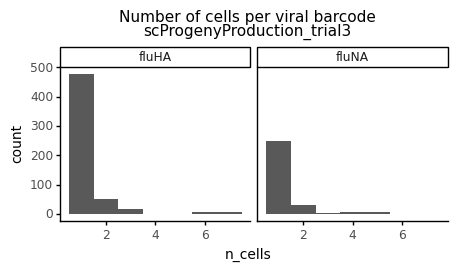

<ggplot: (8767483570429)>

In [20]:
fig = (p9.ggplot(viral_bc_freqs
                 .query('(reject_uninfected == True) and '
                        '(cell_barcode.notna())',
                        engine='python')) +
       p9.geom_histogram(p9.aes(x='n_cell_bc'),
                         binwidth=1,
                         position='dodge') +
       p9.facet_grid('~gene') +
       p9.ggtitle('Number of cells per viral barcode\n'
                  f'{expt}') +
       p9.xlab('n_cells') +
       p9.theme(figure_size=(5, 2),
                plot_title=p9.element_text(size=11),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center'))
display(fig)

Now I will label viral barcodes that are found in more than 1 cells.

In [21]:
viral_bc_freqs['gt1_cell'] = (
    viral_bc_freqs['n_cell_bc'] > 1)

viral_bc_freqs

,cell_barcode,infected,infecting_viral_tag,gene,frac_viral_UMIs,viral_barcode,frac_viral_bc_UMIs,reject_uninfected,freq_progeny,in_infected_cell,n_cell_bc,gt1_cell
0,AAACCCAGTAACAAGT,False,none,fluHA,0.000048,NaN,0.0,False,NaN,False,NaN,False
1,AAACCCATCATTGCTT,False,none,fluHA,0.000051,NaN,0.0,False,NaN,False,NaN,False
2,AAACGAAAGATGTTGA,False,none,fluHA,0.000204,NaN,0.0,False,NaN,False,NaN,False
3,AAACGCTCAAATGATG,False,none,fluHA,0.000107,NaN,0.0,False,NaN,False,NaN,False
4,AAACGCTCATGGACAG,False,none,fluHA,0.000119,NaN,0.0,False,NaN,False,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...
66332,NaN,NaN,wt,fluNA,NaN,TTTTTCCCTTACATAT,NaN,NaN,4.799773e-07,False,NaN,False
66333,NaN,NaN,wt,fluNA,NaN,TTTTTCTTACGATCAC,NaN,NaN,4.799773e-07,False,NaN,False
66334,NaN,NaN,wt,fluNA,NaN,TTTTTCTTCGAGATAG,NaN,NaN,4.799773e-06,False,NaN,False
66335,NaN,NaN,wt,fluNA,NaN,TTTTTGGGATCATTGC,NaN,NaN,9.599545e-07,False,NaN,False


Plot number of viral barcodes that were found in more than 1 cell:

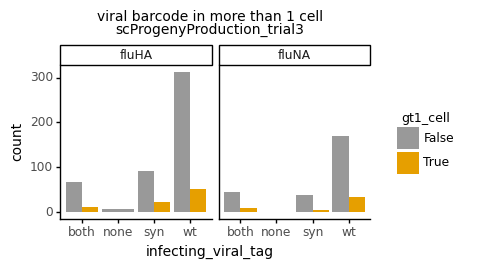

<ggplot: (8767489916139)>

In [22]:
output_fig = (p9.ggplot((viral_bc_freqs
                         .query('(reject_uninfected == True) and '
                                '(cell_barcode.notna())',
                                engine='python')),
                        p9.aes(x='infecting_viral_tag',
                               fill='gt1_cell')) +
              p9.geom_bar(stat='count', position='dodge') +
              p9.ggtitle('viral barcode in more than 1 cell\n'
                         f'{expt}') +
              p9.facet_grid('~gene') +
              p9.theme(figure_size=(4, 2),
                       plot_title=p9.element_text(size=10),
                       axis_title=p9.element_text(size=10),
                       legend_title=p9.element_text(size=9),
                       legend_title_align='center') +
              p9.scale_fill_manual(CBPALETTE[0:]))
display(output_fig)

Plot transcript-supernatant correlation with this info annotated:

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10


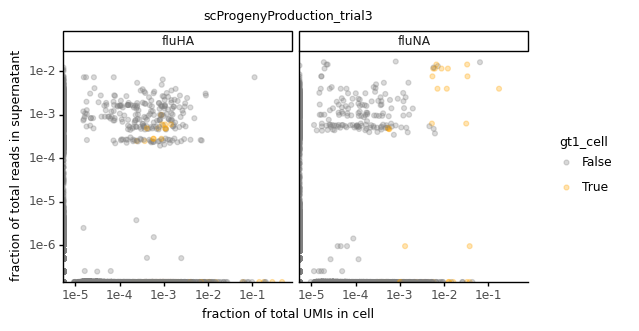

<ggplot: (8767483124788)>

In [23]:
fig = (p9.ggplot(viral_bc_freqs.fillna(0),
                 p9.aes(x='frac_viral_bc_UMIs',
                        y='freq_progeny',
                        color='gt1_cell')) +
       p9.geom_point(alpha=0.3) +
       p9.facet_grid('~gene') +
       p9.ggtitle(f'{expt}') +
       p9.scale_x_log10() +
       p9.scale_y_log10() +
       p9.labs(x='fraction of total UMIs in cell',
               y='fraction of total reads in supernatant') +
       p9.theme(figure_size=(6, 3),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center') +
       p9.scale_color_manual(values=['grey','orange']))
display(fig)

### Viral barcodes per cell
I want to annotate cells with the number of viral barcodes above background on each segment.

Calculate the number of viral barcodes each segment has per cell:

In [24]:
n_viral_bc = (viral_bc_freqs
             .query('(reject_uninfected == True) and '
                    '(cell_barcode.notna())',
                    engine='python')
             .groupby(['infecting_viral_tag',
                       'gene',
                       'cell_barcode',
                       'reject_uninfected'])
             ['viral_barcode']
             .nunique()
             .reset_index()
             .rename(columns={'viral_barcode': 'n_viral_bc'}))

viral_bc_freqs = pd.merge(
    viral_bc_freqs,
    n_viral_bc,
    on=['infecting_viral_tag',
        'gene',
        'cell_barcode',
        'reject_uninfected'],
    how='left')

viral_bc_freqs

,cell_barcode,infected,infecting_viral_tag,gene,frac_viral_UMIs,viral_barcode,frac_viral_bc_UMIs,reject_uninfected,freq_progeny,in_infected_cell,n_cell_bc,gt1_cell,n_viral_bc
0,AAACCCAGTAACAAGT,False,none,fluHA,0.000048,NaN,0.0,False,NaN,False,NaN,False,NaN
1,AAACCCATCATTGCTT,False,none,fluHA,0.000051,NaN,0.0,False,NaN,False,NaN,False,NaN
2,AAACGAAAGATGTTGA,False,none,fluHA,0.000204,NaN,0.0,False,NaN,False,NaN,False,NaN
3,AAACGCTCAAATGATG,False,none,fluHA,0.000107,NaN,0.0,False,NaN,False,NaN,False,NaN
4,AAACGCTCATGGACAG,False,none,fluHA,0.000119,NaN,0.0,False,NaN,False,NaN,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
66332,NaN,NaN,wt,fluNA,NaN,TTTTTCCCTTACATAT,NaN,NaN,4.799773e-07,False,NaN,False,NaN
66333,NaN,NaN,wt,fluNA,NaN,TTTTTCTTACGATCAC,NaN,NaN,4.799773e-07,False,NaN,False,NaN
66334,NaN,NaN,wt,fluNA,NaN,TTTTTCTTCGAGATAG,NaN,NaN,4.799773e-06,False,NaN,False,NaN
66335,NaN,NaN,wt,fluNA,NaN,TTTTTGGGATCATTGC,NaN,NaN,9.599545e-07,False,NaN,False,NaN


Plot distribution of viral barcode per cell. Only look at viral barcodes found above background and present in the transcriptome.

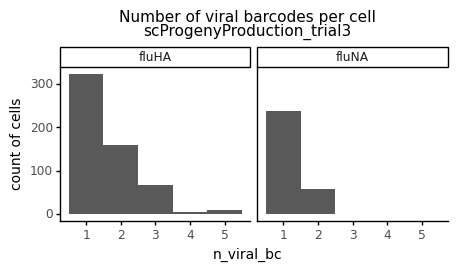

<ggplot: (8767490300712)>

In [25]:
fig = (p9.ggplot(viral_bc_freqs
                 .query('(reject_uninfected == True) and '
                        '(cell_barcode.notna())',
                        engine='python')) +
       p9.geom_histogram(p9.aes(x='n_viral_bc'),
                         binwidth=1,
                         position='dodge') +
       p9.facet_grid('~gene') +
       p9.ggtitle('Number of viral barcodes per cell\n'
                  f'{expt}') +
       p9.xlab('n_viral_bc') +
       p9.ylab('count of cells') +
       p9.theme(figure_size=(5, 2),
                plot_title=p9.element_text(size=11),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center'))
display(fig)

Now I will label cells that have more than 1 viral barcode on a segment.

In [26]:
viral_bc_freqs['gt1_viral_bc'] = (
    viral_bc_freqs['n_viral_bc'] > 1)

viral_bc_freqs

,cell_barcode,infected,infecting_viral_tag,gene,frac_viral_UMIs,viral_barcode,frac_viral_bc_UMIs,reject_uninfected,freq_progeny,in_infected_cell,n_cell_bc,gt1_cell,n_viral_bc,gt1_viral_bc
0,AAACCCAGTAACAAGT,False,none,fluHA,0.000048,NaN,0.0,False,NaN,False,NaN,False,NaN,False
1,AAACCCATCATTGCTT,False,none,fluHA,0.000051,NaN,0.0,False,NaN,False,NaN,False,NaN,False
2,AAACGAAAGATGTTGA,False,none,fluHA,0.000204,NaN,0.0,False,NaN,False,NaN,False,NaN,False
3,AAACGCTCAAATGATG,False,none,fluHA,0.000107,NaN,0.0,False,NaN,False,NaN,False,NaN,False
4,AAACGCTCATGGACAG,False,none,fluHA,0.000119,NaN,0.0,False,NaN,False,NaN,False,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66332,NaN,NaN,wt,fluNA,NaN,TTTTTCCCTTACATAT,NaN,NaN,4.799773e-07,False,NaN,False,NaN,False
66333,NaN,NaN,wt,fluNA,NaN,TTTTTCTTACGATCAC,NaN,NaN,4.799773e-07,False,NaN,False,NaN,False
66334,NaN,NaN,wt,fluNA,NaN,TTTTTCTTCGAGATAG,NaN,NaN,4.799773e-06,False,NaN,False,NaN,False
66335,NaN,NaN,wt,fluNA,NaN,TTTTTGGGATCATTGC,NaN,NaN,9.599545e-07,False,NaN,False,NaN,False


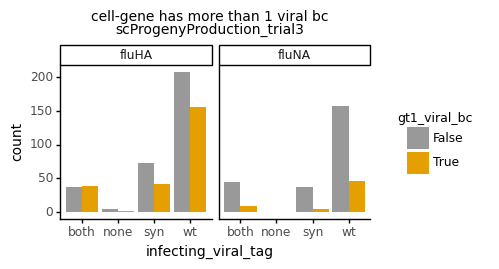

<ggplot: (8767495320537)>

In [27]:
output_fig = (p9.ggplot((viral_bc_freqs
                         .query('(reject_uninfected == True) and '
                                '(cell_barcode.notna())',
                                engine='python')),
                        p9.aes(x='infecting_viral_tag',
                               fill='gt1_viral_bc')) +
              p9.geom_bar(stat='count', position='dodge') +
              p9.ggtitle('cell-gene has more than 1 viral bc\n'
                         f'{expt}') +
              p9.facet_grid('~gene') +
              p9.theme(figure_size=(4, 2),
                       plot_title=p9.element_text(size=10),
                       axis_title=p9.element_text(size=10),
                       legend_title=p9.element_text(size=9),
                       legend_title_align='center') +
              p9.scale_fill_manual(CBPALETTE[0:]))
display(output_fig)

Plot transcriptome-supernatant correlation with this information annotated:

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10


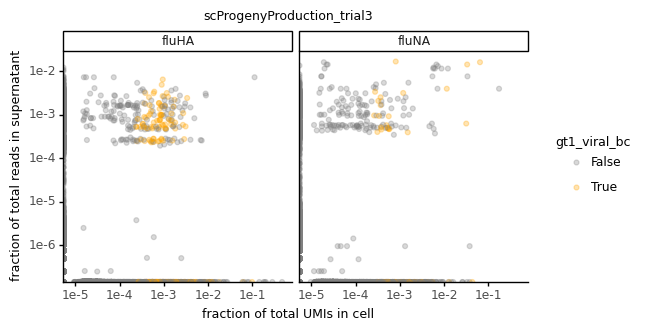

<ggplot: (8767480580060)>

In [28]:
fig = (p9.ggplot(viral_bc_freqs.fillna(0),
                 p9.aes(x='frac_viral_bc_UMIs',
                        y='freq_progeny',
                        color='gt1_viral_bc')) +
       p9.geom_point(alpha=0.3) +
       p9.facet_grid('~gene') +
       p9.ggtitle(f'{expt}') +
       p9.scale_x_log10() +
       p9.scale_y_log10() +
       p9.labs(x='fraction of total UMIs in cell',
               y='fraction of total reads in supernatant') +
       p9.theme(figure_size=(6, 3),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center') +
       p9.scale_color_manual(values=['grey','orange']))
display(fig)

### Viral barcode rank in cell
I will rank each viral barcode in each cell-gene. I will see what fraction of all viral barcode UMIs each viral barcode accounts for.

To do this, I will:
* Group viral barcodes by cell-gene
* Sum fraction of cell UMIs that are assigned to any viral barcode in that cell-gene
* Rank only viral barcodes **that are significant above uninfected background**
* Plot rank vs fraction of viral barcode UMIs

In [29]:
cell_total_frac_viral_bc_UMIs = (
    viral_bc_freqs
    .groupby(['cell_barcode','gene'])
    ['frac_viral_bc_UMIs']
    .sum()
    .reset_index()
    .rename(
    columns={'frac_viral_bc_UMIs': 'cell_total_frac_viral_bc_UMIs'}))

viral_bc_freqs = pd.merge(
    left=viral_bc_freqs,
    right=cell_total_frac_viral_bc_UMIs,
    on=['cell_barcode',
        'gene'],
    how='left')

viral_bc_freqs

,cell_barcode,infected,infecting_viral_tag,gene,frac_viral_UMIs,viral_barcode,frac_viral_bc_UMIs,reject_uninfected,freq_progeny,in_infected_cell,n_cell_bc,gt1_cell,n_viral_bc,gt1_viral_bc,cell_total_frac_viral_bc_UMIs
0,AAACCCAGTAACAAGT,False,none,fluHA,0.000048,NaN,0.0,False,NaN,False,NaN,False,NaN,False,0.0
1,AAACCCATCATTGCTT,False,none,fluHA,0.000051,NaN,0.0,False,NaN,False,NaN,False,NaN,False,0.0
2,AAACGAAAGATGTTGA,False,none,fluHA,0.000204,NaN,0.0,False,NaN,False,NaN,False,NaN,False,0.0
3,AAACGCTCAAATGATG,False,none,fluHA,0.000107,NaN,0.0,False,NaN,False,NaN,False,NaN,False,0.0
4,AAACGCTCATGGACAG,False,none,fluHA,0.000119,NaN,0.0,False,NaN,False,NaN,False,NaN,False,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66332,NaN,NaN,wt,fluNA,NaN,TTTTTCCCTTACATAT,NaN,NaN,4.799773e-07,False,NaN,False,NaN,False,NaN
66333,NaN,NaN,wt,fluNA,NaN,TTTTTCTTACGATCAC,NaN,NaN,4.799773e-07,False,NaN,False,NaN,False,NaN
66334,NaN,NaN,wt,fluNA,NaN,TTTTTCTTCGAGATAG,NaN,NaN,4.799773e-06,False,NaN,False,NaN,False,NaN
66335,NaN,NaN,wt,fluNA,NaN,TTTTTGGGATCATTGC,NaN,NaN,9.599545e-07,False,NaN,False,NaN,False,NaN


In [30]:
viral_bc_freqs['cell_total_frac_viral_bc_UMIs'].value_counts(dropna=False)

NaN         57147
0.000000     4851
0.100567       41
0.113515       35
0.066219       33
            ...  
0.000017        1
0.001482        1
0.000020        1
0.000033        1
0.000036        1
Name: cell_total_frac_viral_bc_UMIs, Length: 1828, dtype: int64

In [31]:
viral_bc_freqs['prop_cell_viral_bc_UMIs'] = (
    viral_bc_freqs['frac_viral_bc_UMIs'] /
    viral_bc_freqs['cell_total_frac_viral_bc_UMIs']
)

viral_bc_freqs['prop_cell_viral_bc_UMIs'].value_counts(dropna=False)

NaN         61998
1.000000     1063
0.500000      224
0.333333       49
0.000174       38
            ...  
0.764706        1
0.103448        1
0.100000        1
0.441860        1
0.435897        1
Name: prop_cell_viral_bc_UMIs, Length: 1282, dtype: int64

In [32]:
viral_bc_freqs['viral_bc_rank'] = (viral_bc_freqs
                                   .query('reject_uninfected == True')
                                   .groupby(['cell_barcode','gene'])
                                   ['prop_cell_viral_bc_UMIs']
                                   .rank())
viral_bc_freqs['viral_bc_rank'].value_counts()

1.0    690
2.0    129
3.0     25
1.5      8
4.0      3
5.0      2
Name: viral_bc_rank, dtype: int64

Plot distribution of viral barcode ranks. Only look at viral barcodes present in the transcriptome and found above background frequency.

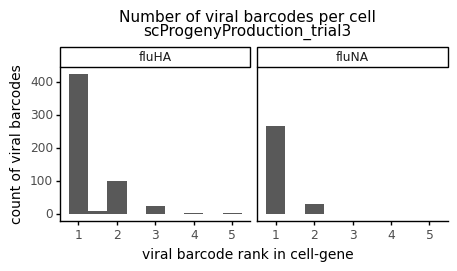

<ggplot: (8767493745270)>

In [33]:
fig = (p9.ggplot(viral_bc_freqs
                 .query('(reject_uninfected == True) and '
                        '(cell_barcode.notna())',
                        engine='python')) +
       p9.geom_histogram(p9.aes(x='viral_bc_rank'),
                         binwidth=0.5,
                         position='dodge') +
       p9.facet_grid('~gene') +
       p9.ggtitle('Number of viral barcodes per cell\n'
                  f'{expt}') +
       p9.xlab('viral barcode rank in cell-gene') +
       p9.ylab('count of viral barcodes') +
       p9.theme(figure_size=(5, 2),
                plot_title=p9.element_text(size=11),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center'))
display(fig)

In [34]:
viral_bc_freqs['top_viral_bc'] = (viral_bc_freqs['viral_bc_rank'] == 1)
viral_bc_freqs['top_viral_bc'].value_counts()

False    65647
True       690
Name: top_viral_bc, dtype: int64

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_jitter : Removed 65480 rows containing missing values.
/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/plotnine/guides/guides.py:197: PlotnineWarning: Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it


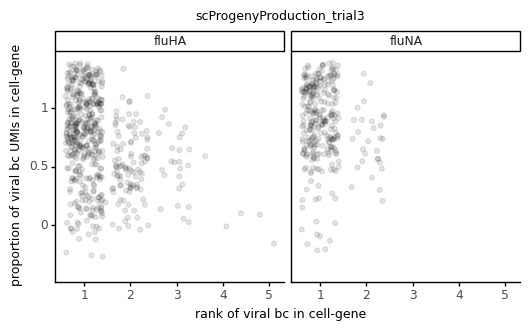

<ggplot: (8767493896885)>

In [35]:
fig = (p9.ggplot((viral_bc_freqs),
                 p9.aes(x='viral_bc_rank',
                        y='prop_cell_viral_bc_UMIs')) +
       p9.geom_jitter(alpha=0.1) +
       p9.facet_grid('~gene') +
       p9.ggtitle(f'{expt}') +
       p9.labs(x='rank of viral bc in cell-gene',
               y='proportion of viral bc UMIs in cell-gene') +
       p9.theme(figure_size=(6, 3),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center') +
       p9.scale_color_manual(values=['orange','grey']))
display(fig)

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_point : Removed 635 rows containing missing values.


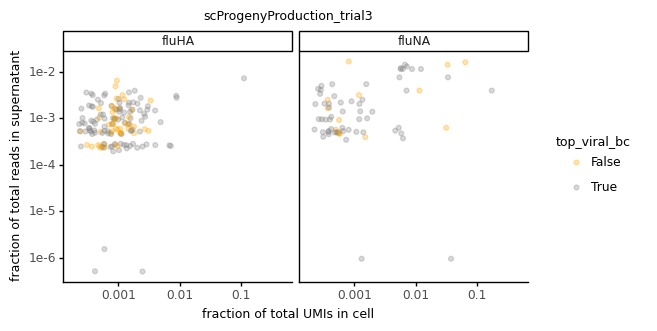

<ggplot: (8767493972785)>

In [36]:
fig = (p9.ggplot(viral_bc_freqs
                 .query('(viral_bc_rank.notna())',
                        engine='python'),
                 p9.aes(x='frac_viral_bc_UMIs',
                        y='freq_progeny',
                        color='top_viral_bc')) +
       p9.geom_point(alpha=0.3) +
       p9.facet_grid('~gene') +
       p9.ggtitle(f'{expt}') +
       p9.scale_x_log10() +
       p9.scale_y_log10() +
       p9.labs(x='fraction of total UMIs in cell',
               y='fraction of total reads in supernatant') +
       p9.theme(figure_size=(6, 3),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center') +
       p9.scale_color_manual(values=['orange','grey']))
display(fig)

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_point : Removed 528 rows containing missing values.
/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/plotnine/guides/guides.py:197: PlotnineWarning: Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it


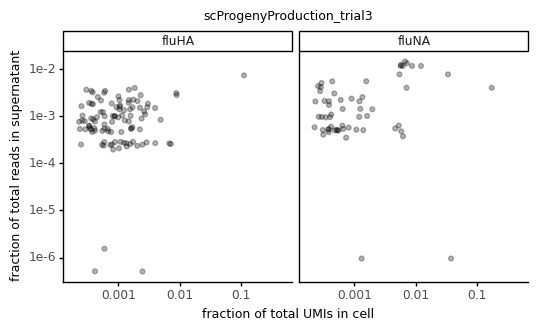

<ggplot: (8767483171612)>

In [37]:
fig = (p9.ggplot(viral_bc_freqs
                 .query('(top_viral_bc == True)'),
                 p9.aes(x='frac_viral_bc_UMIs',
                        y='freq_progeny')) +
       p9.geom_point(alpha=0.3) +
       p9.facet_grid('~gene') +
       p9.ggtitle(f'{expt}') +
       p9.scale_x_log10() +
       p9.scale_y_log10() +
       p9.labs(x='fraction of total UMIs in cell',
               y='fraction of total reads in supernatant') +
       p9.theme(figure_size=(6, 3),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center') +
       p9.scale_color_manual(values=['orange','grey']))
display(fig)

### Viral burden
Plot the viral burden (total fraction of viral UMIs in cell) against the most abundant viral barcode.

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/plotnine/guides/guides.py:197: PlotnineWarning: Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it


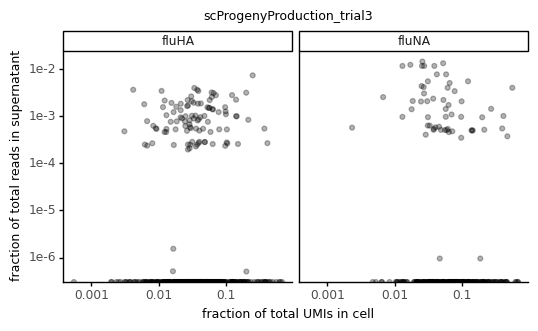

<ggplot: (8767483133070)>

In [39]:
fig = (p9.ggplot(viral_bc_freqs
                 .fillna(0)
                 .query('(top_viral_bc == True)'),
                 p9.aes(x='frac_viral_UMIs',
                        y='freq_progeny')) +
       p9.geom_point(alpha=0.3) +
       p9.facet_grid('~gene') +
       p9.ggtitle(f'{expt}') +
       p9.scale_x_log10() +
       p9.scale_y_log10() +
       p9.labs(x='fraction of total UMIs in cell',
               y='fraction of total reads in supernatant') +
       p9.theme(figure_size=(6, 3),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center') +
       p9.scale_color_manual(values=['orange','grey']))
display(fig)